# Example of loading and analysing the UCM

This notebook walks through loading and analysing a trained UCM. For large scale experiments, the model analysis code should be put into a Python script to keep the workflow clean and allow parallel processing of many different models.

### Table of contents

1. [**Loading a trained model**](#loading)
2. [**Assessing goodness-of-fit**](#assess)
3. [**Computing spike count distributions**](#SCD)
4. [**Inspecting model parameters**](#inspect)

In [1]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

plt.style.use(['paper.mplstyle'])

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


<a id='loading'></a>
## 1. Loading a trained model

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [2]:
 mice_sessions = {
    'Mouse12': ['120806', '120807', '120809', '120810' ], # '120808' is missing position files
    'Mouse17': ['130125', '130128', '130129', '130130', '130131', '130201', '130202', '130203', '130204'],
    'Mouse20': ['130514', '130515', '130516', '130517'], # '130520' hdc models fails
    'Mouse24': ['131213', '131216', '131217','131218'],
    'Mouse25': ['140123', '140124', '140128', '140129', '140130', '140131', '140203', '140204', '140205', '140206'],
    'Mouse28': ['140310', '140311', '140312', '140313', '140317', '140318'],
} 


In [5]:
for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc']:
            phase='wake'
            bin_size=160
            single_spikes = False
            dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path='/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/')

            print(np.max(dataset_dict['spiketrains']))

units:  85  hdc units:  22
28.0
units:  88  hdc units:  14
30.0
units:  225  hdc units:  14
30.0
units:  95  hdc units:  10
36.0
units:  21  hdc units:  2
19.0
units:  46  hdc units:  7
20.0
units:  58  hdc units:  11
44.0
units:  53  hdc units:  13
48.0
units:  50  hdc units:  7
23.0
units:  53  hdc units:  6
21.0
units:  55  hdc units:  5
13.0
units:  59  hdc units:  7
20.0
units:  52  hdc units:  7
25.0
units:  11  hdc units:  2
10.0
units:  13  hdc units:  4
15.0
units:  17  hdc units:  4
57.0
units:  22  hdc units:  6
26.0
units:  28  hdc units:  5
14.0
units:  41  hdc units:  10
25.0
units:  40  hdc units:  11
26.0
units:  43  hdc units:  11
24.0
units:  41  hdc units:  12
28.0
units:  36  hdc units:  10
27.0
units:  32  hdc units:  5
10.0
units:  33  hdc units:  11
19.0
units:  38  hdc units:  16
35.0
units:  40  hdc units:  18
28.0
units:  31  hdc units:  13
30.0
units:  39  hdc units:  18
32.0
units:  37  hdc units:  13
25.0
units:  28  hdc units:  7
27.0
units:  56  hdc units

In [6]:
mice_sessions = {'Mouse12': ['120806']}

Mouse12-120806-hdc
units:  85  hdc units:  22


/homes/vn283/UCM-interpret/example/../scripts/HDC.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  kernel_tuples += [('SE', 'torus', torch.tensor(ang_ls))]


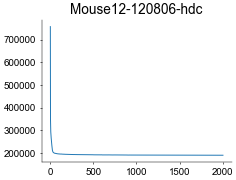

In [10]:
for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc']:#, 'nonhdc']:
            try:
                phase = 'wake'

                print(f'{mouse_id}-{session_id}-{subset}')
                bin_size = 160  # ms

                # data
                single_spikes = False
                dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path='/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/')

                model_dict = {
                    'seed': 123, 
                    'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                    'filt_mode': '',  # GLM couplings
                    'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                    'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                    'z_mode': '',  # latent covariates
                    'hist_len': 0, 
                    'folds': 5, 
                    'delays': [0], 
                    'neurons': dataset_dict['neurons'], 
                    'max_count': dataset_dict['max_count'], 
                    'bin_size': dataset_dict['bin_size'], 
                    'tbin': dataset_dict['tbin'], 
                    'model_name': dataset_dict['name'], 
                    'tensor_type': torch.float, 
                    'jitter': 1e-5, 
                }

                checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
                cv_run = -1  # test set is last 1/5 of dataset time series
                delay = 0
                batch_size = 5000  # size of time segments of each batch in dataset below

                # model and train/test split based on which validation fold is given by cv_run
                modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )
                plt.plot(training_results['training_loss'])
                plt.title(f'{mouse_id}-{session_id}-{subset}')
                plt.show()
            except FileNotFoundError:
                continue

In [31]:
dataset_dict['covariates']

{'hd': array([3.52111562, 3.58917753, 3.60591807, ..., 4.84782006, 4.92795866,
        5.0328527 ]),
 'omega': array([1.36123824, 0.33481074, 0.32539611, ..., 1.60277193, 2.09788083,
        2.09788083]),
 'speed': array([27.3013698 , 18.68254374, 14.63283956, ...,  0.16917216,
         2.67304548,  2.67304548]),
 'x': array([77.71560743, 77.39676088, 77.16619443, ..., 45.72784033,
        45.72177586, 45.67905628]),
 'y': array([65.07858503, 63.75127615, 62.84605092, ..., 63.061873  ,
        63.06776963, 63.19441073]),
 'time': array([0.00000e+00, 5.00000e-02, 1.00000e-01, ..., 2.18860e+03,
        2.18865e+03, 2.18870e+03])}

Now we load the model checkpoint for a given settings, along with the training data. The checkpoint name is determined internally by the model architecture specified above and the dataset that we load.

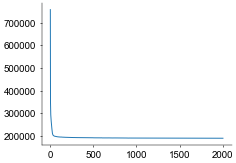

In [22]:
checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

# model and train/test split based on which validation fold is given by cv_run
modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)
plt.plot(training_results['training_loss'])

<a id='assess'></a>
## 2. Assessing goodness-of-fit

We can evaluate the held-out test log likelihood with the above. Repeating over all folds will give us $k$-fold cross-validation, in this case we have $k=5$. Below we compute the test log likelihood for one fold.

In [16]:
# LL
train = validation_set[1]
ts = train+1.

ll = lib.helper.RG_pred_ll(
    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
    ll_samples=1, cov_samples=1, beta=0.0
)
print(ll)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [20]:
#rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, data_name = dataset_tuple

# 2D search, so there will be steps**2 = 10000 covariate vector inputs
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
    
units_used = dataset_dict['neurons']
    
# quantiles, Z scores
P_ = []
for b in range(modelfit.input_group.batches):
    covariates, _ = modelfit.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = lib.helper.compute_P(modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(units_used):
    batch_edge, _, _ = modelfit.likelihood.batch_info
    spike_binned = modelfit.likelihood.all_spikes[trial, n, :].numpy()
    q_, Z_ = lib.helper.get_q_Z(P[n, ...], spike_binned, deq_noise=None)
    q.append(q_)
    Z.append(Z_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)
Z = np.array(Z)  # Z scores of shape (neurons, timesteps)

RuntimeError: CUDA out of memory. Tried to allocate 4.28 GiB (GPU 0; 7.77 GiB total capacity; 1.02 GiB already allocated; 1.45 GiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [ ]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)

In [ ]:
x = np.linspace(0, 0.01, 100)
f = utils.stats.KS_sampling_dist(x, len(q[0]))
plt.plot(x, f)
plt.hist(T_KS_bn, bins=np.linspace(0, 0.01, 50), density=True)
plt.show()

If single neuron statistics are captured well, we could still have correlations between the $Z$-scores that indicate neural correlations not explained by the input covariates. For instance, a neuron pair could happen to fire more or less spikes than their average during similar periods, which will show up as positive correlations between the $Z$-scores. If the model captures all correlations, i.e. it accounts for all co-fluctuations between neuron pairs, then we should see only insignificant correlations.

In [ ]:
# neural correlations
R = np.zeros((units_used, units_used))
R_p = []
for n in range(units_used):
    for k in range(n+1, units_used):
        r, r_p = sc.stats.pearsonr(Z[n], Z[k]) # Pearson r correlation test
        R[n, k] = r
        R_p.append(r_p)
        
R = R + R.T  # symmetrize
R_p = np.array(R_p)

In [ ]:
Rmax = max(-R.min(), R.max())

fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.imshow(R, cmap=weight_map, vmin=-Rmax, vmax=Rmax)
ax.set_xlabel('neuron $i$')
ax.set_ylabel('neuron $j$')
ax.set_title('noise correlations')
ax.set_xticks(np.arange(units_used))
ax.set_yticks(np.arange(units_used))

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)

plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.hist(R_p, bins=np.linspace(0, 1, 50), density=True)
ylims = ax.get_ylim()
ax.plot(2*[0.05], ylims, 'k--')
ax.set_xlabel(r'$p$-values of correlations')
plt.show()

<a id='SCD'></a>
## 3. Computing spike count distributions

Now we load a model that has been trained on the entire dataset, which we specify by setting ```cv_run = -1```.

In [23]:
bin_size = 50  # ms
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below

    
# data
dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path='/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/')

# model and train/test split based on which validation fold is given by cv_run
#modelfit, fit_set, validation_set = lib.models.load_model(
#    checkpoint_dir, model_info, dataset_tuple, HDC.inputs_used, HDC.enc_used, 
#    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5
#)

units:  85  hdc units:  22


We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [24]:
hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

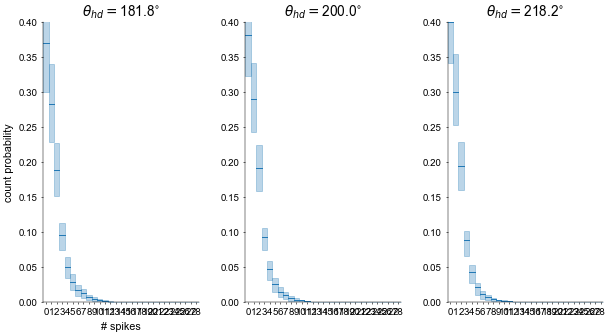

In [25]:
# histograms
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ne = 20  # select neuron
K = P_mc.shape[-1]
for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    
    for k in range(K):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2)*mean.numpy()[ne, step_ind, k]
        YY_l = np.ones(2)*lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2)*upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(K))
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()

Conventional tuning curves show mean firing rate as a function of some covariate. We can plot those by computing the mean of the count distribution.

In [26]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

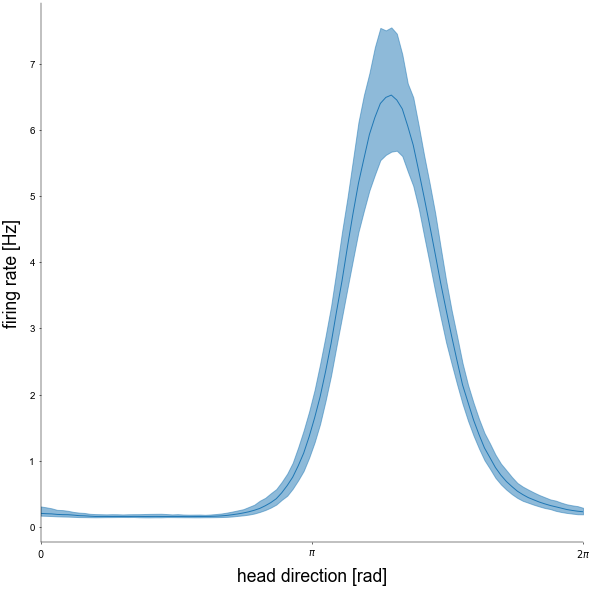

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 1  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate [Hz]', fontsize=18)
ax.set_xlabel('head direction [rad]', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

(100,)
(100,)


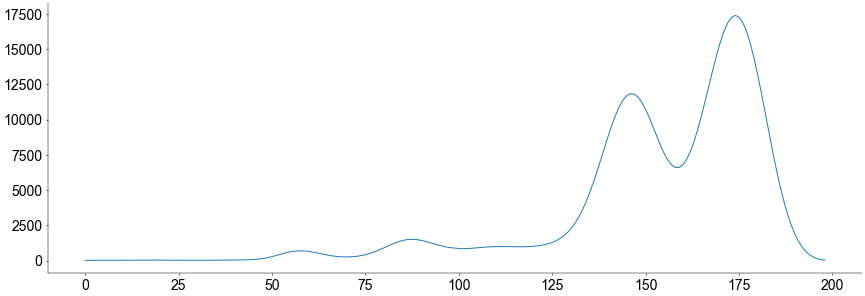

In [28]:
# compute cross correlations

# neurons to compare
ne1 = 15
ne2 = 18
print(mean[ne1, :].numpy().shape)
print(mean[ne2, :].numpy().shape)

correlations = np.correlate(mean[ne1, :].numpy(), mean[ne2, :].numpy(), mode='full')

fig, ax = plt.subplots()
ax.plot(correlations)

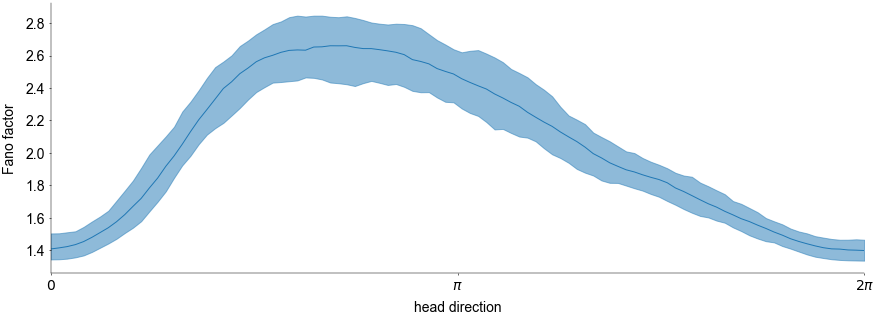

In [29]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 20  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('Fano factor')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

### 3.1. Firing rate with respect to two covariates

In [30]:
# 2D search, so there will be steps**2 = 10000 covariate vector inputs

steps = 100
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)

covariates = torch.cat([
    hd_sweep[:, None].expand(-1, steps).reshape(steps**2, 1),
    rcov[1].mean()*torch.ones((steps**2, 1)),
    v_sweep[None, :].expand(steps, -1).flatten().reshape(steps**2, 1),
    *[rcov[k].mean()*torch.ones((steps**2, 1)) for k in range(3, len(rcov))],
], dim=-1)[None, None, ...] # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

RuntimeError: CUDA out of memory. Tried to allocate 8.56 GiB (GPU 0; 7.77 GiB total capacity; 457.55 MiB already allocated; 1.45 GiB free; 4.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
K = P.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

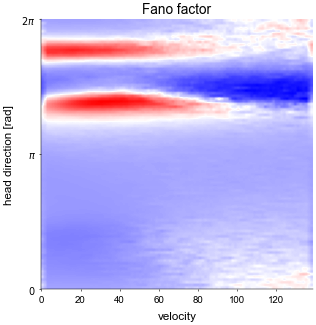

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])
ne = 16  # select neuron to plot

# mean has shape (neurons, steps**2), need to unpack it again
mean = mean.reshape((-1, steps, steps))

ax.imshow(mean[ne, :], cmap=weight_map, extent=[np.min(rcov[2]), np.max(rcov[2]), 0, 2*np.pi], aspect='auto')
ax.set_xlabel('velocity')
ax.set_ylabel('head direction [rad]')
ax.set_title('Fano factor')

ax.set_yticks([0, np.pi, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

plt.show()

Generally, if we want to only look at tuning to one behavioural covariate, we should marginalize out the modulation from all other covariates. This cannot be done in closed form, hence we need to use Monte Carlo sampling where we treat the observed behaviour as a chain of samples and average out over those values conditioned on the relevant behavioural covariate fixed at our evaluation value. This is an expensive operation and implemented in ```scripts/lib/count_stats.py```.


<a id='inspect'></a>
## 4. Inspecting model parameters

We can load all the kernel hyperparameters, which govern how quickly the neural tuning fluctuates with changes in covariates. The kernel module is a nested module (a product kernel with separable kernels over each covariate dimension). For the circular lengthscale, values way above $2\pi$ indicate little variation in the GP function with head direction, i.e. it is a redundant degree of freedom w.r.t. the head direction (approximately a constant function).

In [20]:
print(modelfit.mapping.kernel.kern0.kern1.track_dims)  # this is a circular kernel over the head direction (covariate dimension 0)
print(modelfit.mapping.kernel.kern1.track_dims)  # this is a Euclidean kernel over other behavioural covariates (dimensions 1 to 5)

[0]
[1, 2, 3, 4, 5]


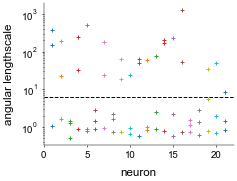

In [21]:
lengthscales = modelfit.mapping.kernel.kern0.kern1.lengthscale.reshape(units_used, -1).data.cpu().numpy()
C = lengthscales.shape[-1]

fig, ax = plt.subplots()

for n in range(units_used):
    ax.scatter((n + 1)*np.ones(C), lengthscales[n, :], marker='+', s=10)
    
ax.plot([0, units_used+1], [2*np.pi, 2*np.pi], 'k--')
ax.set_xlim([0, units_used+1])
ax.set_yscale('log')

ax.set_ylabel('angular lengthscale')
ax.set_xlabel('neuron')
    
plt.show()

The above only holds for one covariate dimension that we looked at. To look at the intrinsic degree of freedom for a neuron, it may be more informative and convenient to look at the softmax weights and biases that connect the GP functions to the spike count distribution. We now load the pre-softmax weights and biases. Each neuron has its own set of weights and biases $W_n$ and $\mathbf{b}_n$. Note we used a exponential-quadratic expansion for $\phi(\cdot)$. This expansion combines the quadratic basis expansion with an exponential mapping, i.e. for a vector $\mathbf{f} = (f_1, f_2)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_1^2, f_2^2, e^{f_1}, e^{f_2}, f_1 f_2)
$$

and for a vector $\mathbf{f} = (f_1, f_2, f_3)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, f_1^2, f_2^2, f_3^2, e^{f_1}, e^{f_2}, e^{f_3}, f_1 f_2, f_2 f_3, f_1 f_3)
$$

and so on. The last example here corresponds to the case of $C = 3$ as in the model that we loaded. The probability of spike count $k$ for neuron $n$ is then computed as 

$$
P_{nk} = \text{softmax}\left( W_n \cdot \phi(\mathbf{f}_n) + \mathbf{b}_n \right)_k
$$

Different basis expansions $\phi(\cdot)$ are defined in ```scripts/lib/models.py```.

In [22]:
print(modelfit.likelihood.mapping_net.mnet.net[0].weight.shape)  # (neuron, count, phi(f) dimension)
print(modelfit.likelihood.mapping_net.mnet.net[0].bias.shape)  # (neuron, count)

torch.Size([21, 11, 12])
torch.Size([21, 11])


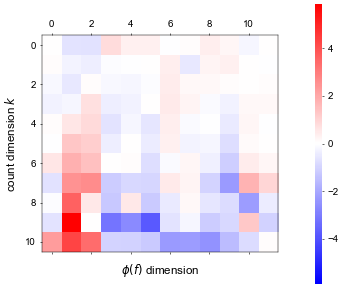

In [23]:
ne = 20  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())


fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
ax.set_xlabel(r'$\phi(f)$ dimension')
ax.set_ylabel(r'count dimension $k$')

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)
    
plt.show()

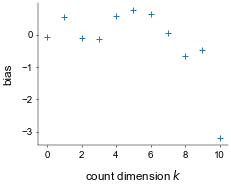

In [24]:
ne = 20  # select neuron
bn = modelfit.likelihood.mapping_net.mnet.net[0].bias[ne, :].data.cpu().numpy()

fig, ax = plt.subplots()
ax.scatter(np.arange(bn.shape[0]), bn, marker='+', s=30)
ax.set_ylabel('bias')
ax.set_xlabel(r'count dimension $k$')
plt.show()